# Trail des Glières

# Libraries

In [1]:
import pandas as pd
import numpy as np

import re
import datetime

# Graphs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import files

In [2]:
resultats_21km_duo = pd.read_csv('resultats_21km_duo.csv',sep=';')
resultats_21km_solo = pd.read_csv('resultats_21km_solo.csv',sep=';')

In [3]:
# Clean and delete last 6 rows
resultats_21km_solo = resultats_21km_solo[:-6]

# Create a unique dataframe

In [4]:
# Add a new column 'Type' to each dataframe
resultats_21km_duo['Type'] = 'duo'
resultats_21km_solo['Type'] = 'solo'

In [5]:
# Combine resultats_21km_duo and resultats_21km_solo into a single dataframe
df = pd.concat([resultats_21km_solo, resultats_21km_duo], ignore_index=True)
df.head()

,Pl.,Dos,Unnamed: 2,Nom,Club,Sx,Cat,Par cat.,Sous Dine,Landron,Pré Arrivée,Temps,Ecart,Moy,Type
0,1,2120,FRA,FICHEUX Enzo,NaN,Homme,S-M0H,1.0,01:16:34,01:30:15,01:56:45,01:58:37,NaN,"10,6",solo
1,2,2035,FRA,GENAND Leo,ARVE ATHLÉTISME,Homme,S-M0H,2.0,01:16:08,01:31:04,01:59:03,02:00:41,+02:04,"10,4",solo
2,3,2246,FRA,THIVOLET Mattéo,ENTENTE ARVE ATHLÉTISME,Homme,S-M0H,3.0,01:26:08,01:41:34,02:09:44,02:11:25,+12:48,"9,6",solo
3,4,2146,FRA,BLAZER Tanguy,NaN,Homme,S-M0H,4.0,01:27:14,01:43:10,02:12:07,02:13:59,+15:22,"9,4",solo
4,5,2240,FRA,HURTAULT Romain,NaN,Homme,M1-5H,1.0,01:28:15,01:43:50,02:14:41,02:16:37,+18:00,"9,2",solo


In [6]:
# Rename unnamed column
df = df.rename(columns={'Unnamed: 2': 'Nationalite'})

# 0. Data Quality

## General information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pl.          349 non-null    object 
 1   Dos          349 non-null    int64  
 2   Nationalite  349 non-null    object 
 3   Nom          349 non-null    object 
 4   Club         69 non-null     object 
 5   Sx           349 non-null    object 
 6   Cat          349 non-null    object 
 7   Par cat.     349 non-null    float64
 8   Sous Dine    344 non-null    object 
 9   Landron      346 non-null    object 
 10  Pré Arrivée  345 non-null    object 
 11  Temps        349 non-null    object 
 12  Ecart        347 non-null    object 
 13  Moy          349 non-null    object 
 14  Type         349 non-null    object 
dtypes: float64(1), int64(1), object(13)
memory usage: 41.0+ KB


## Data type

In [8]:
# Modify data type of 'Pl.' and 'Par cat.' columns to integer
df["Pl."] = pd.to_numeric(df["Pl."], errors="coerce").astype("Int64")
df["Par cat."] = pd.to_numeric(df["Par cat."], errors="coerce").astype("Int64")

In [9]:
# Modify data type of time columns to timedelta
df["Sous Dine"] = pd.to_timedelta(df["Sous Dine"], errors="coerce")
df["Landron"] = pd.to_timedelta(df["Landron"], errors="coerce")
df["Pré Arrivée"] = pd.to_timedelta(df["Pré Arrivée"], errors="coerce")
df["Temps"] = pd.to_timedelta(df["Temps"], errors="coerce")

In [10]:
def pad_time(val):
    if pd.isna(val):
        return val
    val = val.replace("+", "")
    # If format is MM:SS (no hours), pad with 00:
    if re.fullmatch(r"\d{1,2}:\d{2}", val):
        return "00:" + val
    return val

In [11]:
# Convert 'Ecart' to timedelta
df["Ecart"] = df["Ecart"].apply(pad_time)
df["Ecart"] = pd.to_timedelta(df["Ecart"], errors="coerce")

In [12]:
# Replace comma with dot and convert to float
df["Moy"] = pd.to_numeric(df["Moy"].str.replace(",", ".", regex=False), errors="coerce").astype(float)

In [13]:
# Add a new column with the time and Ecart in seconds
df['Temps_sec'] = df['Temps'].dt.total_seconds().astype(int)
df['Ecart_sec'] = df['Ecart'].dt.total_seconds().astype('Int64')

## Missing data

In [14]:
df.isna().sum()

Pl.              0
Dos              0
Nationalite      0
Nom              0
Club           280
Sx               0
Cat              0
Par cat.         0
Sous Dine        5
Landron          3
Pré Arrivée      4
Temps            0
Ecart            2
Moy              0
Type             0
Temps_sec        0
Ecart_sec        2
dtype: int64

In [15]:
# Check missing values
df[df['Ecart'].isnull()]

,Pl.,Dos,Nationalite,Nom,Club,Sx,Cat,Par cat.,Sous Dine,Landron,Pré Arrivée,Temps,Ecart,Moy,Type,Temps_sec,Ecart_sec
0,1,2120,FRA,FICHEUX Enzo,NaN,Homme,S-M0H,1,0 days 01:16:34,0 days 01:30:15,0 days 01:56:45,0 days 01:58:37,NaT,10.6,solo,7117,<NA>
222,1,2626,FRA,LOBRY Josué / VESSE Maxime,ANNECY ATHLÉTISME,Homme,HOM,1,0 days 01:26:19,0 days 01:41:55,0 days 02:11:00,0 days 02:12:53,NaT,9.5,duo,7973,<NA>


Missing "Ecart" values correspond to the first of each group (solo / duo)

## Description des données

In [16]:
df.describe(include='all')

,Pl.,Dos,Nationalite,Nom,Club,Sx,Cat,Par cat.,Sous Dine,Landron,Pré Arrivée,Temps,Ecart,Moy,Type,Temps_sec,Ecart_sec
count,349.0,349.000000,349,349,69,349,349,349.0,344,346,345,349,347,349.000000,349,349.000000,347.0
unique,<NA>,NaN,8,349,52,3,10,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,<NA>
top,<NA>,NaN,FRA,FICHEUX Enzo,SALÈVE TRAIL,Homme,S-M0H,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,solo,NaN,<NA>
freq,<NA>,NaN,338,1,6,177,83,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,222,NaN,<NA>
mean,94.2149,2299.435530,NaN,NaN,NaN,NaN,NaN,28.017192,0 days 02:11:34.276162790,0 days 02:39:49.945086705,0 days 03:32:16.202898550,0 days 03:34:50.214899713,0 days 01:31:33.198847262,6.064470,NaN,12890.214900,5493.198847
std,60.284166,216.450227,NaN,NaN,NaN,NaN,NaN,19.935088,0 days 00:21:04.981407536,0 days 00:27:05.789627509,0 days 00:38:15.754102810,0 days 00:38:26.463697935,0 days 00:36:48.779096284,1.160608,NaN,2306.463698,2208.779096
min,1.0,2001.000000,NaN,NaN,NaN,NaN,NaN,1.0,0 days 01:16:08,0 days 01:30:15,0 days 01:56:45,0 days 01:58:37,0 days 00:02:04,4.000000,NaN,7117.000000,124.0
25%,44.0,2114.000000,NaN,NaN,NaN,NaN,NaN,12.0,0 days 01:57:22.250000,0 days 02:20:24.750000,0 days 03:03:55,0 days 03:06:16,0 days 01:07:39,5.200000,NaN,11176.000000,4059.0
50%,88.0,2227.000000,NaN,NaN,NaN,NaN,NaN,24.0,0 days 02:10:47,0 days 02:38:26.500000,0 days 03:31:25,0 days 03:33:57,0 days 01:29:45,5.900000,NaN,12837.000000,5385.0
75%,135.0,2544.000000,NaN,NaN,NaN,NaN,NaN,42.0,0 days 02:26:22.250000,0 days 02:59:07.500000,0 days 03:58:20,0 days 04:00:44,0 days 01:57:21.500000,6.800000,NaN,14444.000000,7041.5


## Wrong data

In [17]:
df[['Sx', 'Cat']].drop_duplicates().values

array([['Homme', 'S-M0H'],
       ['Homme', 'M1-5H'],
       ['Femme', 'S-M0F'],
       ['Femme', 'M1-5F'],
       ['Homme', 'FEM'],
       ['Femme', 'JEUF'],
       ['Homme', 'JEUH'],
       ['Homme', 'M6+H'],
       ['Homme', 'HOM'],
       ['Mixte', 'MX'],
       ['Femme', 'FEM']], dtype=object)

In [18]:
df[(df['Sx'] == 'Homme') & (df['Cat'] == 'FEM')]

,Pl.,Dos,Nationalite,Nom,Club,Sx,Cat,Par cat.,Sous Dine,Landron,Pré Arrivée,Temps,Ecart,Moy,Type,Temps_sec,Ecart_sec
12,13,2526,FRA,MERINO Pierrick,NaN,Homme,FEM,1,0 days 01:37:31,0 days 01:56:25,0 days 02:31:37,0 days 02:33:53,0 days 00:35:16,8.2,solo,9233,2116


Cat seems to be wrong. Instead of FEM we will replace with the most common Cat for Sx = Homme

In [19]:
# Find the most common Cat for Sx = 'Homme'
most_common_cat = df.loc[df['Sx'] == 'Homme', 'Cat'].mode()[0]

# Replace 'FEM' with the most common Cat for Homme
df.loc[(df['Sx'] == 'Homme') & (df['Cat'] == 'FEM'), 'Cat'] = most_common_cat

# Save data file

In [20]:
df.to_csv('df.csv', index=False) 

# Graphs

In [21]:
TYPE_COLORS = {
    "duo": "#48494B", 
    "solo": "#999DA0"
    }

GENDER_COLORS = {
    "Homme": "#4169E1", 
    "Femme": "#FF69B4", 
    "Mixte": "#a6d854"
    }

TYPE_GENDER_COLORS = {
    ("duo", "Mixte"): "#a6d854",
    ("duo", "Femme"): "#e78ac3",
    ("duo", "Homme"): "#8da0cb",
    ("solo", "Mixte"): "#a6d854",
    ("solo", "Femme"): "#f7cde3",
    ("solo", "Homme"): "#c3cee5"
}

CATEGORY_COLORS = {
    "MX": "#a6d854",
    "FEM": "#e78ac3",
    "HOM": "#8da0cb",
    "JEUF": "#f7cde3",
    "S-M0F": "#f7cde3",
    "M1-5F": "#f7cde3",
    "JEUH": "#c3cee5",
    "S-M0H": "#c3cee5",
    "M1-5H": "#c3cee5",
    "M6+H": "#c3cee5"
    }

In [22]:
type_order = ["duo", "solo"]
solo_order = ["JEUH", "S-M0H", "M1-5H", "M6+H", "JEUF", "S-M0F", "M1-5F"]
duo_order = ["HOM", "MX", "FEM"]
cat_order = solo_order + duo_order

In [23]:
def plot_bar(data, x, y, palette, xlabel, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
    
    # Style
    sns.despine(bottom=True, left=True)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.yaxis.set_visible(False)
    
    # Annotate bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1%}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.02), ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

In [24]:
def plot_box(data, x, y, palette, xlabel, ylabel, title, highlight_id=None, highlight_color="red", highlight_marker=".", ax=None, order=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=data, x=x, y=y, palette=palette, ax=ax, order=order)

    # Ajout du point à surligner (si fourni)
    if highlight_id is not None:
        sns.stripplot(
            data=data[data["Dos"] == highlight_id],
            x=x,
            y=y,
            color=highlight_color,
            marker=highlight_marker,
            size=6,
            ax=ax,
            label=f"Dossard {highlight_id}"
        )
    # Format axe Y en hh:mm:ss
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=int(x)))))

    # Style
    sns.despine(bottom=True, left=True)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Legend
    ax.legend(loc='upper center', frameon=False)

    plt.tight_layout()
    plt.show()

# 1. Analyse de la Participation

## Par Nationalité

In [25]:
df_nationalite = df.Nationalite.value_counts(normalize=True).to_frame("distribution").reset_index()
df_nationalite

,Nationalite,distribution
0,FRA,0.968481
1,SUI,0.011461
2,GBR,0.005731
3,GER,0.002865
4,SWE,0.002865
5,ESP,0.002865
6,POL,0.002865
7,BRA,0.002865


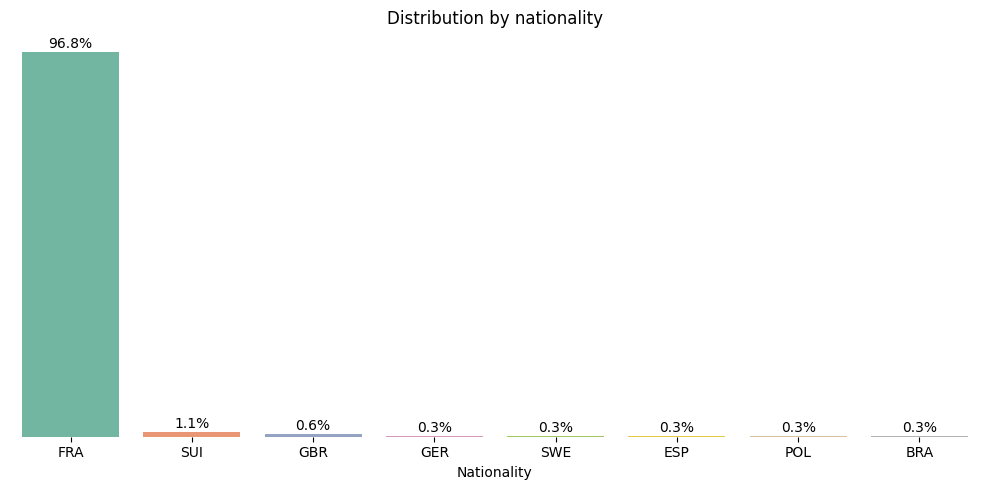

In [26]:
# Clean and consistent bar plot for nationality
plot_bar(
    data=df_nationalite,
    x="Nationalite",
    y="distribution",
    palette="Set2",
    xlabel="Nationality",
    title="Distribution by nationality"
)

## Par Type solo / duo

In [27]:
df_type = df.Type.value_counts(normalize=True).to_frame("distribution").reset_index()
df_type

,Type,distribution
0,solo,0.636103
1,duo,0.363897


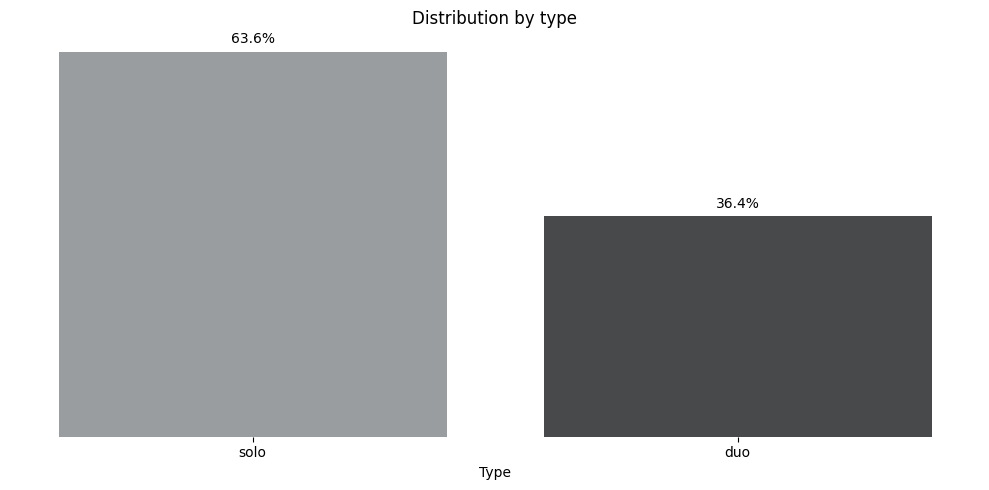

In [28]:
# Plot
plot_bar(
    data=df_type,
    x="Type",
    y="distribution",
    palette=TYPE_COLORS,
    xlabel="Type",
    title="Distribution by type"
)

## Par Sexe

In [29]:
df_sexe = df.Sx.value_counts(normalize=True).to_frame("distribution").reset_index()
df_sexe

,Sx,distribution
0,Homme,0.507163
1,Femme,0.315186
2,Mixte,0.177650


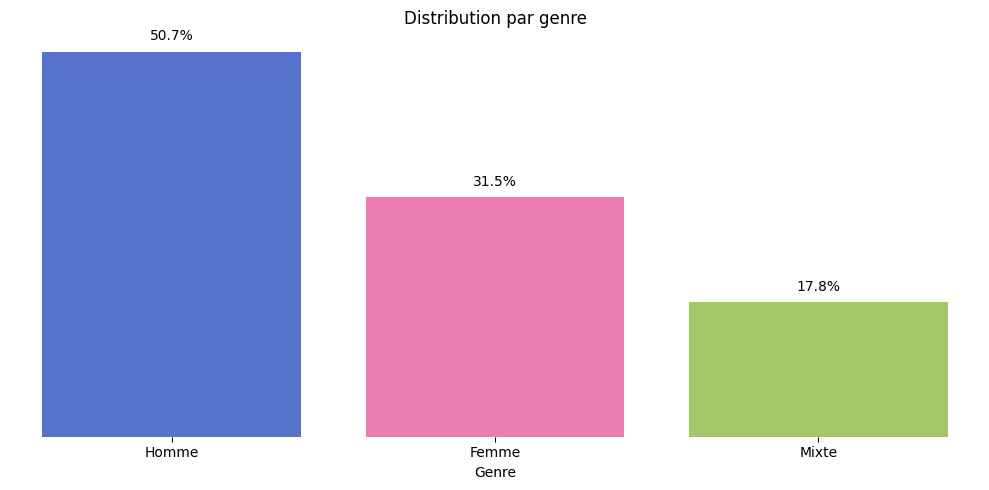

In [30]:
# Plot
plot_bar(
    data=df_sexe,
    x="Sx",
    y="distribution",
    palette=GENDER_COLORS,  # déjà défini plus haut
    xlabel="Genre",
    title="Distribution par genre"
)

## Par Type et Catégorie 

In [31]:
# Distribution of categories by type
df_type_categorie = (
    df.groupby('Type')['Cat']
      .value_counts(normalize=True)
      .rename('distribution')
      .reset_index()
)

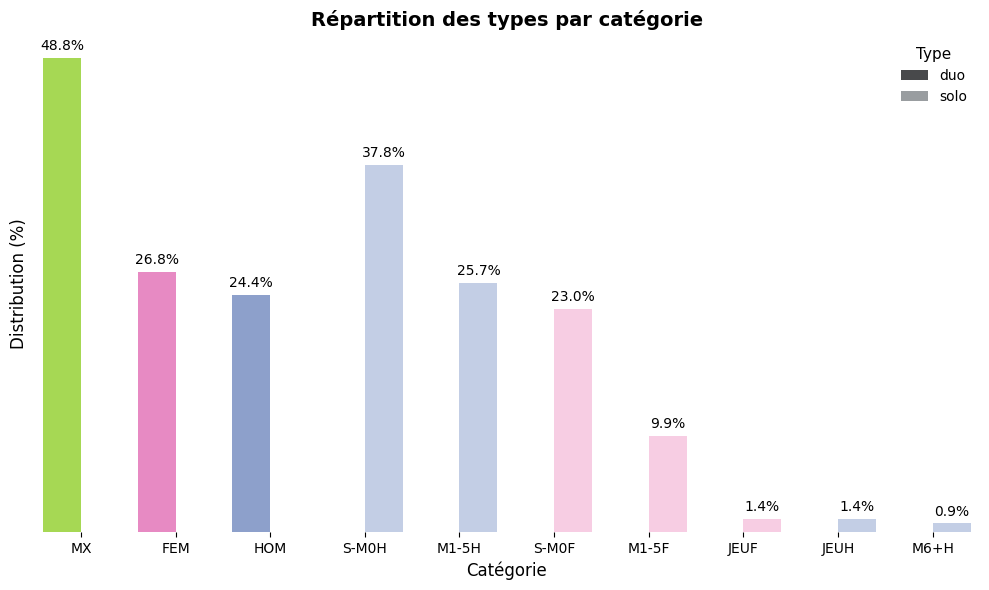

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df_type_categorie,
    x="Cat",
    y="distribution",
    hue="Type",
    hue_order=type_order,
    palette=["#cccccc", "#bbbbbb"],  # temporaire, on recolore après
    ax=ax,
    dodge=True
)

# Recolorie chaque barre selon la catégorie
palette_categorie = df_type_categorie["Cat"].map(CATEGORY_COLORS).tolist()

for bar, color in zip(ax.patches, palette_categorie):
    bar.set_facecolor(color)

# Axes
sns.despine(bottom=True, left=True)
ax.set_xlabel("Catégorie", fontsize=12)
ax.set_ylabel("Distribution (%)", fontsize=12)
ax.set_yticks([]) 
ax.set_title("Répartition des types par catégorie", fontsize=14, fontweight='bold')

# Annoter les barres
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(f'{height:.1%}',
                    (p.get_x() + p.get_width() / 2, height + 0.005),
                    ha='center', va='bottom', fontsize=10, color='black')

# Legend
legend_elements = [
    Patch(facecolor=TYPE_COLORS["duo"], label="duo"),
    Patch(facecolor=TYPE_COLORS["solo"], label="solo")
]
ax.legend(handles=legend_elements, title="Type", title_fontsize=11, fontsize=10, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

## Par Type et Sexe 

In [33]:
df_type_sexe = (
    df.groupby('Type')['Sx']
      .value_counts(normalize=True)
      .rename('distribution')
      .reset_index()
)

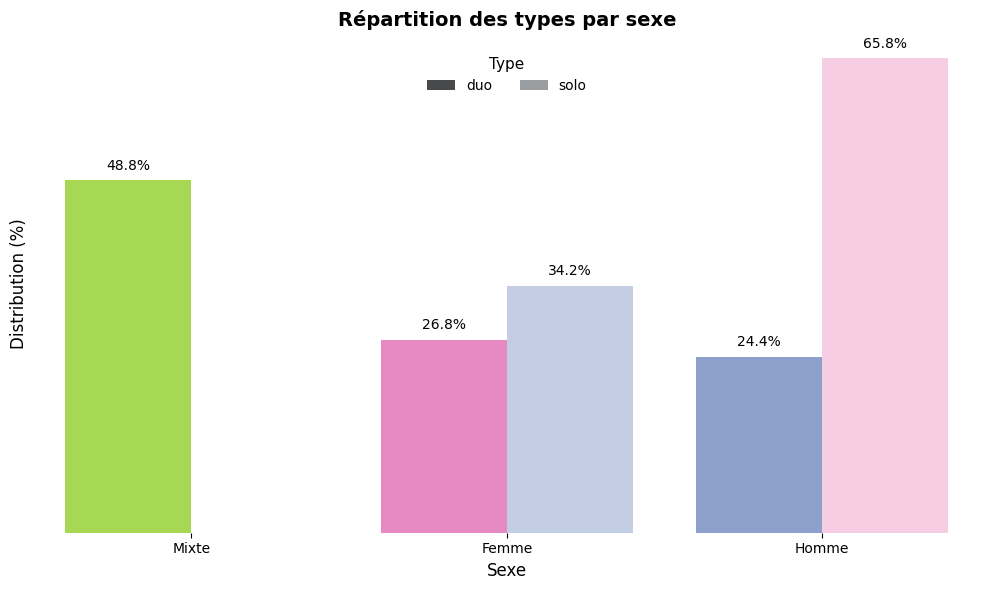

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df_type_sexe,
    x="Sx",
    y="distribution",
    hue="Type",
    hue_order=type_order,
    dodge=True,
    ax=ax,
    palette=["#cccccc", "#bbbbbb"]  # placeholder
)

# Recoloration manuelle des barres
df_type_sexe["color"] = df_type_sexe.apply(lambda row: TYPE_GENDER_COLORS.get((row["Type"], row["Sx"])), axis=1)
palette = df_type_sexe["color"].tolist()

for bar, color in zip(ax.patches, palette):
    bar.set_facecolor(color)

# Style
sns.despine(bottom=True, left=True)
ax.set_xlabel("Sexe", fontsize=12)
ax.set_ylabel("Distribution (%)", fontsize=12)
ax.set_title("Répartition des types par sexe", fontsize=14, fontweight='bold')
ax.set_yticks([])

# Annoter les barres
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(f'{height:.1%}',
                    (p.get_x() + p.get_width() / 2, height + 0.01),
                    ha='center', va='bottom', fontsize=10, color='black')

# Legend
legend_elements = [
    Patch(facecolor=TYPE_COLORS["duo"], label="duo"),
    Patch(facecolor=TYPE_COLORS["solo"], label="solo")
]
ax.legend(
    handles=legend_elements,
    title="Type",
    title_fontsize=11,
    fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.98),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

# 2. Analyse des Performances

## Général

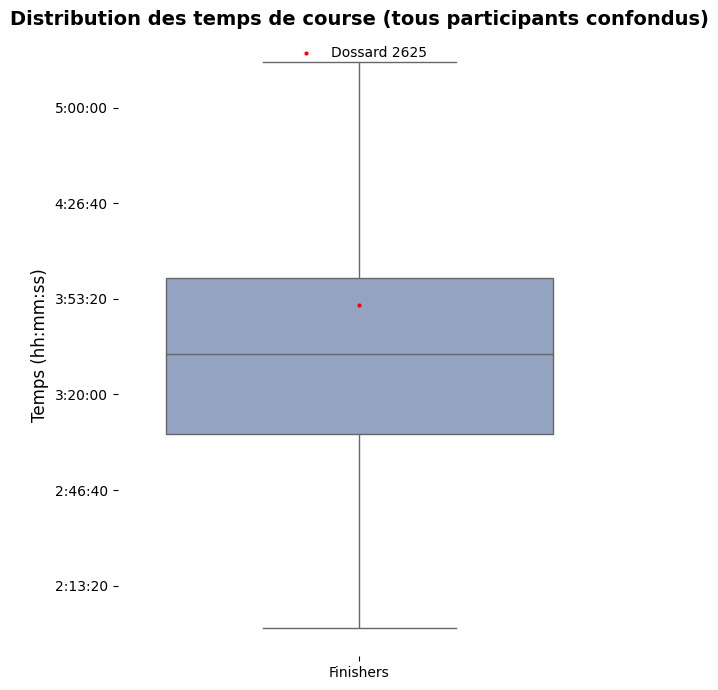

<Figure size 640x480 with 0 Axes>

In [35]:
df["Finishers"] = "Finishers"

fig, ax = plt.subplots(figsize=(6, 7))

plot_box(
    data=df,
    x="Finishers",
    y="Temps_sec",
    palette={"Finishers": "#8da0cb"},
    xlabel="",
    ylabel="Temps (hh:mm:ss)",
    title="Distribution des temps de course (tous participants confondus)",
    highlight_id=2625,
    ax=ax
)

ax.set_xticks([])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Par Nationalité

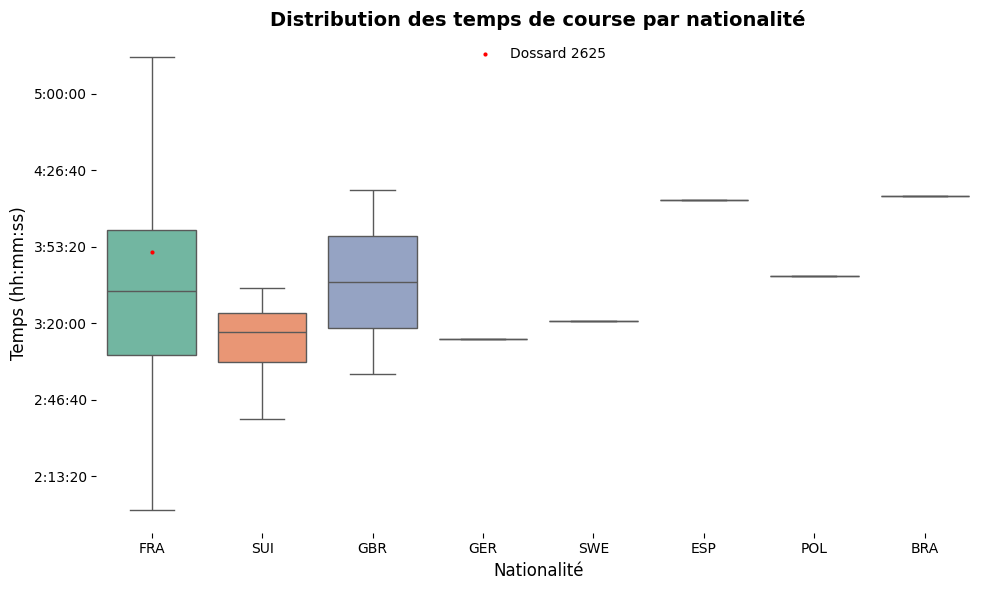

In [36]:
plot_box(
    data=df,
    x="Nationalite",
    y="Temps_sec",
    palette="Set2",
    xlabel="Nationalité",
    ylabel="Temps (hh:mm:ss)",
    title="Distribution des temps de course par nationalité",
    highlight_id=2625
)

## Par Type solo / duo

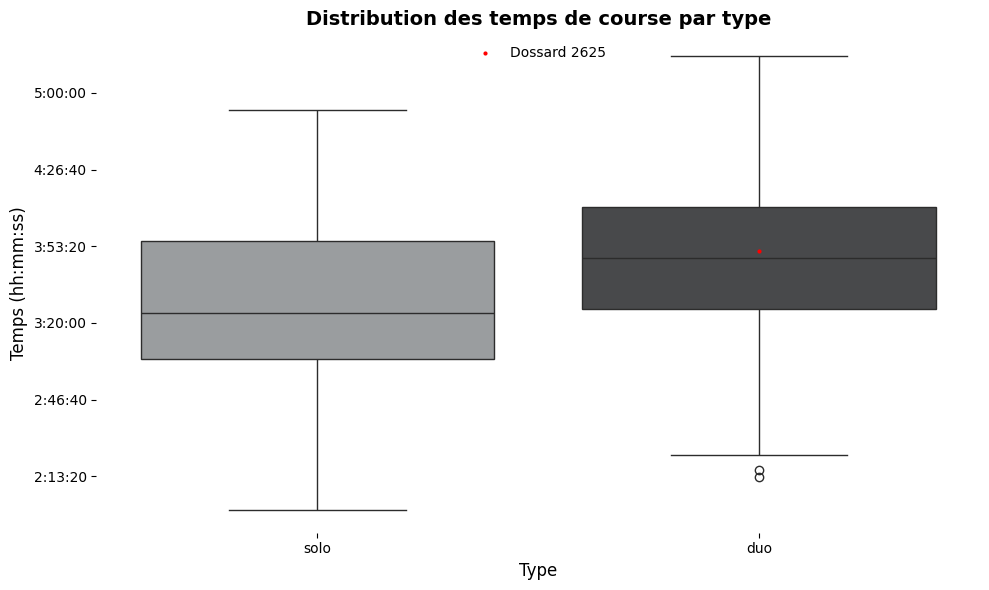

In [37]:
plot_box(
    data=df,
    x="Type",
    y="Temps_sec",
    palette=TYPE_COLORS,
    xlabel="Type",
    ylabel="Temps (hh:mm:ss)",
    title="Distribution des temps de course par type",
    highlight_id=2625
)

## Par Sexe

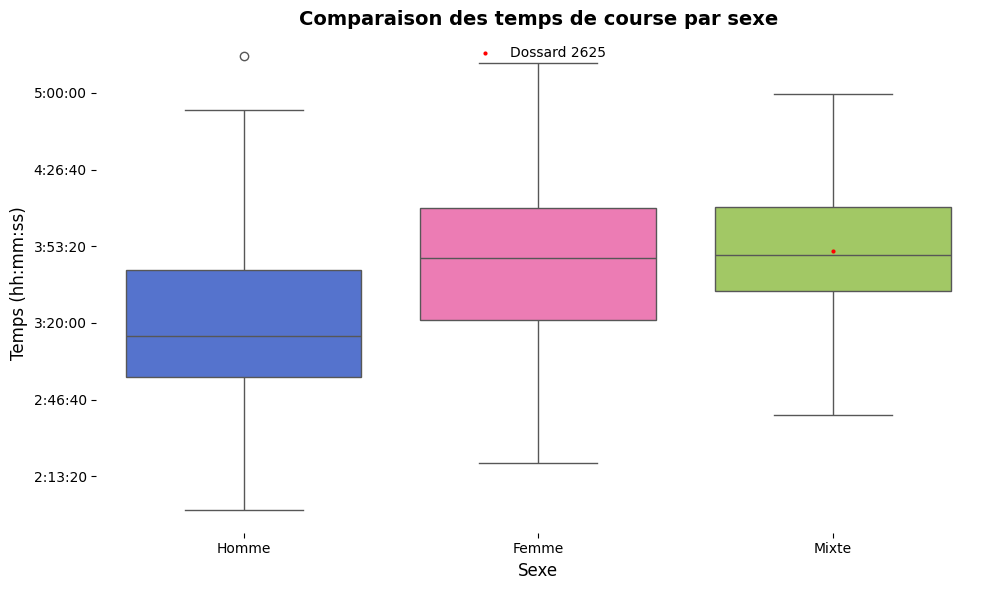

In [38]:
plot_box(
    data=df,
    x="Sx",
    y="Temps_sec",
    palette=GENDER_COLORS,
    xlabel="Sexe",
    ylabel="Temps (hh:mm:ss)",
    title="Comparaison des temps de course par sexe",
    highlight_id=2625
)

## Par Type et Catégorie

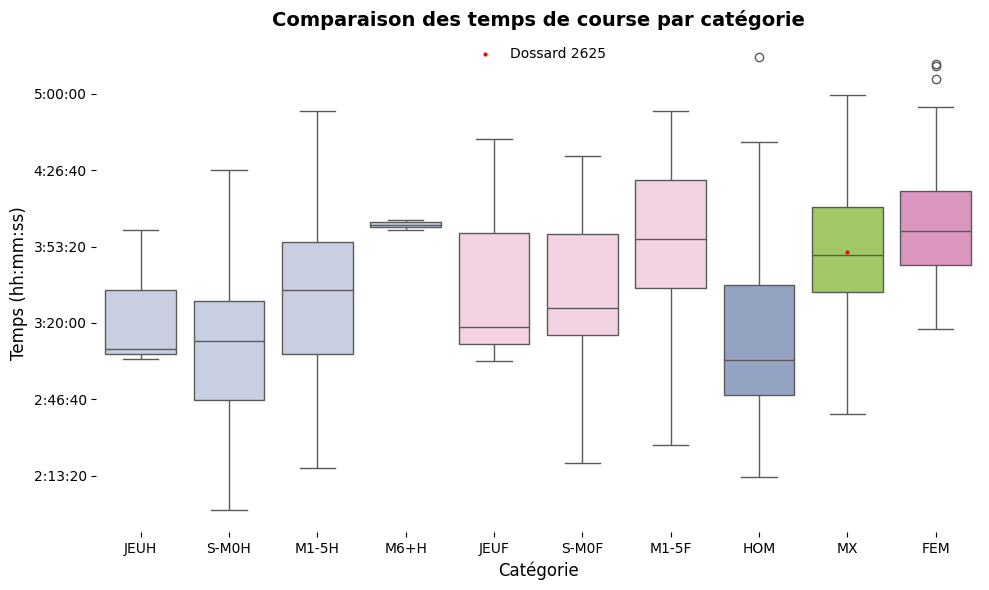

In [39]:
plot_box(
    data=df,
    x="Cat",
    y="Temps_sec",
    palette=CATEGORY_COLORS,
    xlabel="Catégorie",
    ylabel="Temps (hh:mm:ss)",
    title="Comparaison des temps de course par catégorie",
    highlight_id=2625,
    ax=None,
    order=cat_order
)

## Par Type et Sexe

In [40]:
df["Type_Sx"] = df["Type"] + " " + df["Sx"]

color_map = {
    f"{type_} {sx}": color
    for (type_, sx), color in TYPE_GENDER_COLORS.items()
    if f"{type_} {sx}" in df["Type_Sx"].unique()
}

order = [x for x in [
    "duo Homme", "duo Femme", "duo Mixte",
    "solo Homme", "solo Femme"
] if x in df["Type_Sx"].unique()]

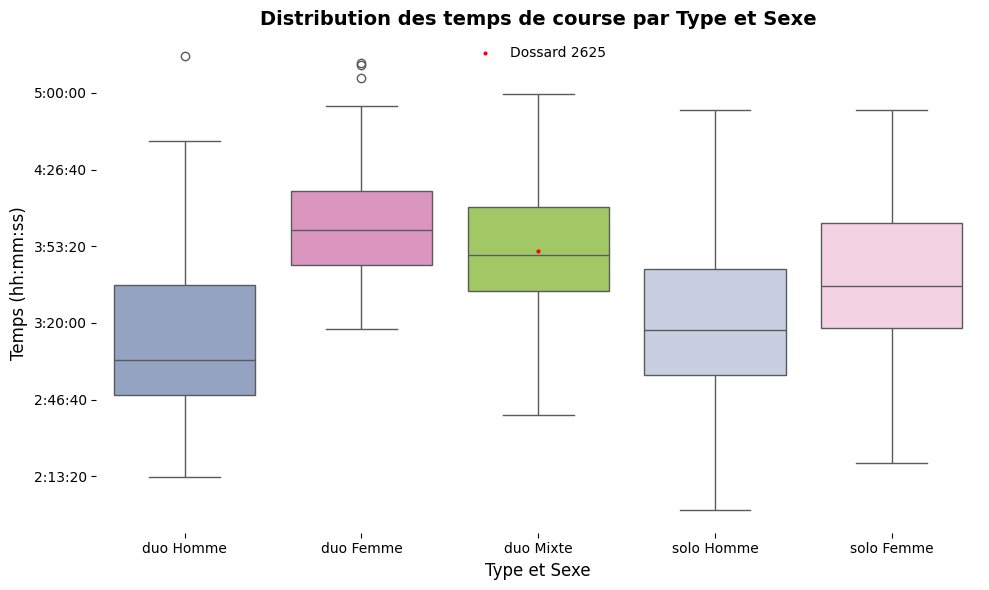

In [41]:
plot_box(
    data=df,
    x="Type_Sx",
    y="Temps_sec",
    palette=color_map,
    xlabel="Type et Sexe",
    ylabel="Temps (hh:mm:ss)",
    title="Distribution des temps de course par Type et Sexe",
    highlight_id=2625,
    order=order
)